In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
#import tensorflow as tf
#assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('font', family = 'simhei')
mpl.rc('font', size = 16)
mpl.rc('axes', unicode_minus = False)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 感知器

In [2]:
# 使用单一感知器分类鸢尾植物类别
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 特征：根茎长度、宽度
y = (iris.target == 0).astype(np.int64)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1], dtype=int64)

展示一下感知器分类的决策平面

Saving figure 单一感知器分类鸢尾植物


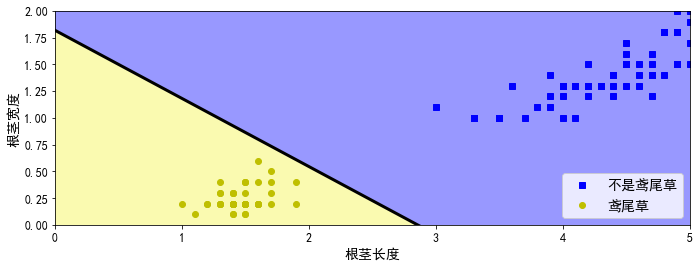

In [3]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="不是鸢尾草")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="鸢尾草")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("根茎长度", fontsize=14)
plt.ylabel("根茎宽度", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("单一感知器分类鸢尾植物")
plt.show()

简单感知器的学习算法非常类似于随机梯度下降，其实当SGDClassifier对象的损失函数是'perceptron'的时候，等同于单一感知器

In [4]:
from sklearn.linear_model import SGDClassifier

per_clf = SGDClassifier(loss = 'perceptron', max_iter=1000, tol=1e-3, random_state=42, penalty = None, 
                        learning_rate = 'constant', eta0 = 1) # 设置学习率保持不变一直为1
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1], dtype=int64)

# 激活函数

In [5]:
# 这是几种流行的激活函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure 几种流行的激活函数


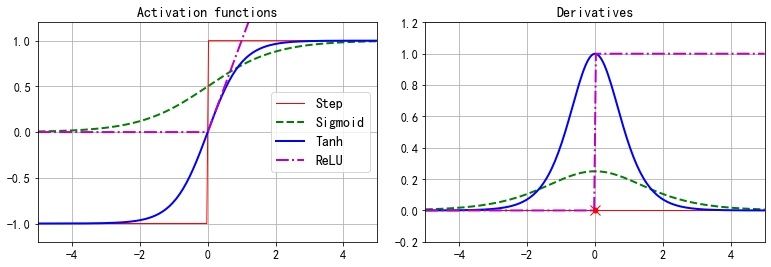

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("几种流行的激活函数")
plt.show()

# keras搭建一个图片分类器

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
import numpy as np

In [9]:
# 获取图片像素数据
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [10]:
X_train_full.shape

(60000, 28, 28)

In [11]:
# 像素值的范围时0-255
X_train_full.dtype

dtype('uint8')

In [12]:
# 因为使用梯度下降来最小化误差，所以需最好先对输入数据进行归一化缩放
# 再分出一点数据作为验证集
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

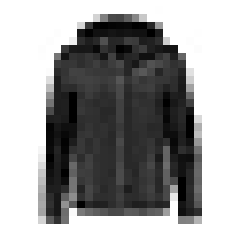

In [13]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [14]:
# 图片共计有10个类别，使用单一数据进行指代
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [15]:
# 这是各个类别的实际含义，如第一个图片是Coat
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names[y_train[0]]

'Coat'

Saving figure fashion_mnist_plot


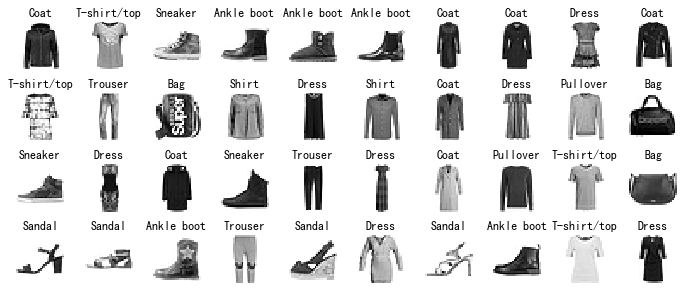

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## 1. 初始化

创建一个最简单的顺序神经网络  
这是两种初始化创建的方法

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
from functools import partial

model = keras.models.Sequential()
# input_shape参数是keras.layers的build()方法的参数
# 当创建一个一个layer时，自动调用build()方法，所以可以使用input_shape参数
model.add(keras.layers.Flatten(input_shape = [28, 28], name = 'input0'))
model.add(keras.layers.Dense(300, activation = partial(keras.activations.relu, alpha = 0.2), name = 'hidden0'))
model.add(keras.layers.Dense(100, activation = partial(keras.activations.relu, alpha = 0.1), name = 'hidden1'))
model.add(keras.layers.Dense(10, activation = keras.activations.softmax, name = 'output0'))

In [19]:
# 重新设置随机状态
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
# 查看模型的layers列表
model.layers

In [21]:
# 还可以看看更详细的列表
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input0 (Flatten)            (None, 784)               0         
                                                                 
 hidden0 (Dense)             (None, 300)               235500    
                                                                 
 hidden1 (Dense)             (None, 100)               30100     
                                                                 
 output0 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


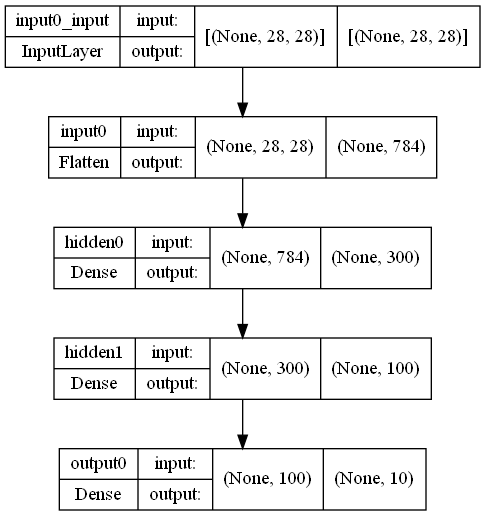

In [22]:
# 也可以看到整个网络的流程图
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [23]:
# 可以通过新的变量单独指定某一个layer
hidden0 = model.layers[1]
hidden0.name

'hidden0'

In [24]:
model.get_layer(hidden0.name) is hidden0

True

In [25]:
# 可以分别获取某一layer的各神经元和偏置项的连接权重，注意此时的权重是随机生成的
# 因为还没进行训练呢
weights, biases = hidden0.get_weights()
# 这是各神经元的连接权重
print(weights.shape)
weights

(784, 300)


array([[ 0.02731763, -0.06621055,  0.00605982, ..., -0.07240466,
        -0.02120525,  0.05278282],
       [-0.06241282, -0.06049016,  0.01791472, ...,  0.02436383,
         0.01472678,  0.03882729],
       [-0.04882829, -0.01506261,  0.02801749, ...,  0.02485556,
         0.06962572,  0.03403612],
       ...,
       [-0.0459898 , -0.0618265 , -0.01060013, ...,  0.07154271,
         0.0210738 , -0.0578726 ],
       [-0.06564844,  0.06558762, -0.02717799, ...,  0.06321692,
         0.02697975, -0.04461583],
       [-0.01383856,  0.0689934 , -0.05113147, ...,  0.03895892,
        -0.03235548, -0.03160469]], dtype=float32)

In [26]:
# 这是偏置项的连接权重，初始化状态可以是0
print(biases.shape)
biases

(300,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## 2. 编译模型

In [27]:
# 在这个环节，可以指定loss函数、优化器、和metrics
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
              optimizer = keras.optimizers.SGD(),
              metrics = [[keras.metrics.sparse_categorical_accuracy]])

## 3. 训练模型

In [28]:
history = model.fit(X_train, y_train, epochs=30, # 进行30个轮次的训练
                    validation_data = (X_valid, y_valid))

Epoch 1/30
 428/1719 [======>.......................] - ETA: 2s - loss: 1.0533 - sparse_categorical_accuracy: 0.6673

KeyboardInterrupt: 

In [ ]:
# 模型训练完成后返回的是History对象，其属性就是模型训练时的各种细节
print('模型参数:', history.params)
print('训练轮次编号:', history.epoch)
print('训练集、验证集的指标:', history.history.keys())

In [ ]:
# 使用history.history中的每个轮次的指标，可以画出学习曲线
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

## 3. 使用测试集对模型进行评估

In [ ]:
# 分别返回loss和metric的值
model.evaluate(X_test, y_test)

## 4. 使用模型进行预测

In [ ]:
# 随便从训练集中取三个实例进行测试
# 可以看到每个类别的概率
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

In [ ]:
# 如果只想要概率最高的类别，可以这么写
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
# 这三个分类的结果是正确的，这是实际的分类
y_new = y_test[:3]
y_new

分类结果可视化

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# 使用顺序API构建一个回归MLP

还是使用加州住房数据进行测试，但是这次输入的住房数据只包含数字型变量

In [ ]:
# 数据前处理
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
# 初始化模型，这次输出层只有一个并且没有激活函数
# 由于数据噪音较多，所以只使用一层隐含层以防止过拟合
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
# 模型编译，注意这次的loss函数变为mean_squared_error
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
# 训练模型
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
# 评估模型
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
# 使用模型预测
y_pred = model.predict(X_new)

In [ ]:
# 画一下子学习曲线
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# 函数式API创建神经网络

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

## 单一输入宽深神经网络

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
# 这既是为什么叫函数式了，直接使用函数调用的方式来连接各个layer
# 这行的意思是input_输入层输出到hidden1隐含层中
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
# 将一部分的输入层的输出直接与hidden2合并后输出
concat = keras.layers.concatenate([input_, hidden2])
# 合并输出后，由输出层输出，只有一个感知器
output = keras.layers.Dense(1)(concat)
# 然后再创建模型，只需指定输入和输出层就行，因为输入与输出层都已经与其它层连接到一起了
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
keras.utils.plot_model(model, "简单的宽深神经网络.png", show_shapes=True)

In [ ]:
model.compile(loss = "mean_squared_error", 
              optimizer = keras.optimizers.SGD(learning_rate=1e-3)
             )

history = model.fit(X_train, y_train, epochs=20,
                    validation_data = (X_valid, y_valid)
                   )
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

## 多输入宽深神经网络

In [ ]:
# 宽路径输入，输入5个变量
input_A = keras.layers.Input(shape=[5], name="wide_input")
# 深路径输入，输入6个变量
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
# 这里注意在创建模型的时候要指定有两个输入
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
keras.utils.plot_model(model, "多输入的宽深神经网络.png", show_shapes=True)

In [ ]:
model.compile(loss = "mse", 
              optimizer = keras.optimizers.SGD(learning_rate=1e-3)
             )

# 这里要注意要将X_train分成两部分输入
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

## 多输出宽深神经网路

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
# 注意指定这两个输出
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [ ]:
keras.utils.plot_model(model, "多输出的宽深神经网络.png", show_shapes=True)

In [ ]:
model.compile(loss=["mape", 'mse'], # 在编译的时候注意，在有多输出的时候可以指定多个损失函数，如果只有一个损失函数，则所有输出都会使用同一个loss
              loss_weights={'main_output':0.9, 'aux_output':0.1}, # 可以指定各个输出在计算损失函数的比重
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )

history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))
mse_test = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred = model.predict([X_new_A, X_new_B])

In [ ]:
# 在评估模型的时候，分别会输出总loss，和分别各个输出的loss
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

In [ ]:
# 使用history.history中的每个轮次的指标，可以画出学习曲线
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

## 使用子类API构建模型

这么做的好处是灵活，可以很方便地调整神经网络的结构，甚至可以在构建模型的时候使用for循环  
但是坏处也非常明显，那就是没办法使用summary或plot_model方法直观地看到神经网络的结构，看不到层与层之间是怎么连接的

In [ ]:
# 是的，只需要继承keras.models.Model类，然后再实现call方法就能构建神经网络了
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        # 在这里先定义好各层
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        # 在call方法中来实现各层的连接
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [ ]:
# 接下来就按照正常的步骤走就行了
model.compile(loss = "mse", 
              loss_weights = [0.9, 0.1], 
              optimizer = keras.optimizers.SGD(learning_rate=1e-3)
             )
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

# 保存和加载模型

使用HDF5格式来保存神经网络的各个层和其对应的所有参数  
但是，这个方法只能保存使用顺序API和函数式API创建的神经网络  
如果想保存使用子类API创建的神经网络，就需要使用save_weights()和load_weights()方法来保存和加载神经网络的所有参数，然后重新构建一遍神经网络，再设置参数

In [ ]:
# 以一个简单的顺序神经网络为例
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

In [ ]:
# 保存模型
model.save("my_keras_model.h5")

In [ ]:
# 加载模型
model = keras.models.load_model("my_keras_model.h5")

In [ ]:
model.predict(X_new)

In [ ]:
# 顺便提一下save_weights()和load_weights()方法的使用
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")

# 在训练期间使用回调函数

当训练时间过长，需要时时保存模型以防止计算机崩溃导致训练失败的时；  
当想实现earlystop时；  
  
就可以使用回调函数：  
需要使用keras.callbacks下的各种类来实现各种回调功能，然后再将keras.callbacks对象列表传递给fit()的callbacks参数就得了  

当然可以自定义一个回调函数
https://keras.io/guides/writing_your_own_callbacks/

In [ ]:
model.compile(loss="mse", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )
# 设置回调函数，在每个轮次epoch结束后，就将当前在验证集中表现最好的模型保存下来
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

model = keras.models.load_model("my_keras_model.h5") # 训练完成后，回滚到表现最佳的模型
mse_test = model.evaluate(X_test, y_test)

In [ ]:
model.compile(loss="mse", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )
# 设置一个earlt stopping的回调功能
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, # 如果10个轮次后在验证集中的表现都没有得到提高，就停止计算
                                                  restore_best_weights=True # 停止训练之后直接自动回滚到最佳的模型，不用自己在手动加载
                                                 )
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    # 是的，可以指定不止一个回调函数
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

In [ ]:
# 自定义一个回调函数，每个轮次计算完成后就输出验证集与训练集的loss比值
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n轮次:{0}\tval/train: {1:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

# Tensorboard

In [ ]:
#指定存放所有log的目录
root_logdir = os.path.join(os.curdir, "my_logs")

In [ ]:
# 设置每次训练完成后都会将训练log记录在时间命名的文件夹下
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# 随便整一个模型
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [ ]:
# 需要使用TensorBoard回调函数，这样才能记录训练时情况
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

## 使用浏览器调出Tensorboard

在装有Tensorflow的环境中打开控制台，在控制台中打开存放有log文件夹的根目录，输入以下命令：

```bash
$ tensorboard --logdir=./my_logs --port=6006
```
然后在浏览器中输入这个http://localhost:6006

## 使用notebook调出Tensorboard

In [ ]:
# 调出Tensorboard
# 加载拓展
%load_ext tensorboard
# 使用6006端口连接Tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [ ]:
# 再训练一遍，在新的文件夹中记录
run_logdir2 = get_run_logdir()
run_logdir2

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

# 调整超参数

可将神经网络的构造函数包装成scikit的回归器，然后使用scikit的一些调参方法来调参

In [ ]:
# 创建神经网络模型的函数
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
from scikeras.wrappers import KerasRegressor
# 包装成一个scikit的回归器对象
keras_reg = KerasRegressor(build_model)
# 然后就可以像真正的回归器一样了，使用fit、score和predict方法
# 只不过这些方法会将参数传递给神经网络对象，score方法得到的就是scikit的分数，不是神经网络的loss
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)